In [1]:
%matplotlib inline

Signal Space Projection (SSP) Math
---------

We can write the measured signal $b \in \mathbb{R}^{C \times T}$ as

$$ b = b_s + b_n$$

where $b_s\in \mathbb{R}^{C \times T}$ is the brain signals and $b_n(t) \in \mathbb{R}^{C \times T}$ is the noise

Noise $b_n$ can be:
* ambient sensor noise
* electrophysiological corruption
 * cardiac
 * ocular

Now, we can apply PCA on $b_n$ and keep only top $M$ components with loadings $ c_n \in \mathbb{R}^M$:
    
$$ b_n = Uc_n + e_n$$

where $U = [b_1, ..., b_M] \in \mathbb{R}^{C \times M}$ are the orthonormal basis.

Now, the SSP operator $P_{\perp} \in \mathbb{R}^{C \times C}$ is given by:

$$ P_{\perp} = I - UU{^\top} $$

so that:

$$b_s \approx P_{\perp}b$$


Artifact Correction with SSP
============================

This tutorial explains how to estimate Signal Subspace Projectors (SSP)
for correction of ECG and EOG artifacts.

In [2]:
import numpy as np

import mne
from mne.datasets import sample
from mne.preprocessing import compute_proj_ecg, compute_proj_eog

# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /home/jovyan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


We can see that the raw data has projectors computed but not yet applied.

In [5]:
#list of projectors; already stored in MEG data
print(raw.info['projs'])


[<Projection  |  PCA-v1, active : False, n_channels : 102>, <Projection  |  PCA-v2, active : False, n_channels : 102>, <Projection  |  PCA-v3, active : False, n_channels : 102>, <Projection  |  Average EEG reference, active : False, n_channels : 60>]


Exercise
------------

Where did these projectors come from? What was the noise $b_n$?

To interactively explore the effect of applying proj, use `raw.plot()` and click on the "proj" button

In [13]:
# raw.plot()

Now, we can apply the projectors by doing:

In [6]:
raw.apply_proj()
print(raw.info['projs'])

Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...
[<Projection  |  PCA-v1, active : True, n_channels : 102>, <Projection  |  PCA-v2, active : True, n_channels : 102>, <Projection  |  PCA-v3, active : True, n_channels : 102>, <Projection  |  Average EEG reference, active : True, n_channels : 60>]


Compute SSP projections
-----------------------

First let's do ECG.



[<Projection  |  PCA-v1, active : True, n_channels : 102>, <Projection  |  PCA-v2, active : True, n_channels : 102>, <Projection  |  PCA-v3, active : True, n_channels : 102>, <Projection  |  Average EEG reference, active : True, n_channels : 60>, <Projection  |  ECG-planar--0.200-0.400-PCA-01, active : False, n_channels : 203>, <Projection  |  ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102>]


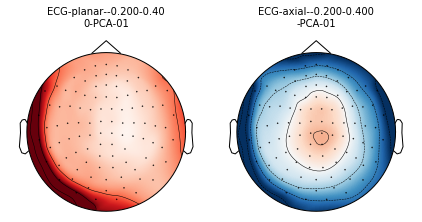

In [7]:
projs, events = compute_proj_ecg(raw, n_grad=1, n_mag=1, n_eeg=0, average=True, verbose=False)
print(projs)

ecg_projs = projs[-2:]
mne.viz.plot_projs_topomap(ecg_projs);
#plot topography of projection vector 
#left - typical of cardiac artifact

Now let's do EOG. Here we compute an EEG projector, and need to pass
the measurement info so the topomap coordinates can be created.



[<Projection  |  PCA-v1, active : True, n_channels : 102>, <Projection  |  PCA-v2, active : True, n_channels : 102>, <Projection  |  PCA-v3, active : True, n_channels : 102>, <Projection  |  Average EEG reference, active : True, n_channels : 60>, <Projection  |  EOG-planar--0.200-0.200-PCA-01, active : False, n_channels : 203>, <Projection  |  EOG-axial--0.200-0.200-PCA-01, active : False, n_channels : 102>, <Projection  |  EOG-eeg--0.200-0.200-PCA-01, active : False, n_channels : 59>]


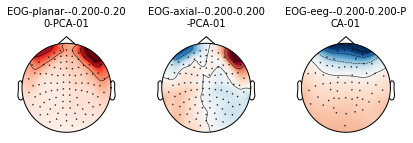

In [8]:
#for EOG
projs, events = compute_proj_eog(raw, n_grad=1, n_mag=1, n_eeg=1, average=True, verbose=False)
print(projs)

eog_projs = projs[-3:]
mne.viz.plot_projs_topomap(eog_projs, info=raw.info);

#need to give info ab chan locs for EEG

Exercise
-------------
What are we plotting here? Is it the SSP operator?

Add SSP projections
---------------------

MNE is handling projections at the level of the info,
so to register them populate the list that you find in the 'proj' field



In [9]:
raw.info['projs'] += eog_projs + ecg_projs
# raw.add_proj will do the same thing
#add items to list
#when compute epochs param called proj; or can do raw.apply_proj (exclusively apply projector)
#active means projectino vectors have been applied; false means haven't been applied 

Now MNE will apply the projs on demand at any later stage,
so watch out for proj parmeters in functions or to it explicitly
with the ``.apply_proj`` method



Demonstrate SSP cleaning on some evoked data
--------------------------------------------



319 events found
Event IDs: [ 1  2  3  4  5 32]


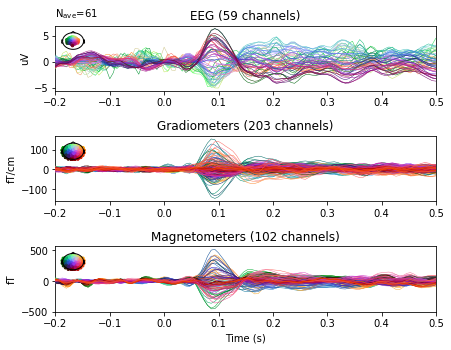

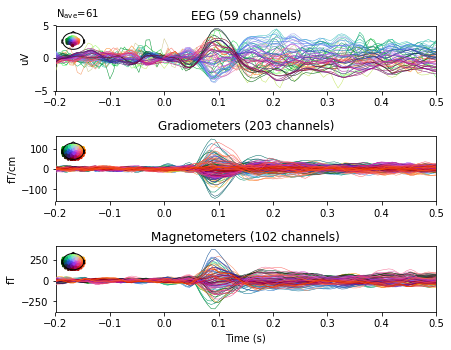

In [10]:
events = mne.find_events(raw, stim_channel='STI 014')
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
# this can be highly data dependent
event_id = {'auditory/right': 2}

epochs_no_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                            proj=False, baseline=(None, 0), reject=reject,
                            verbose=False)
epochs_no_proj.average().plot(spatial_colors=True, time_unit='s');


epochs_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, proj=True,
                         baseline=(None, 0), reject=reject, verbose=False)
epochs_proj.average().plot(spatial_colors=True, time_unit='s');

#see data with and without projector applied; see how it cleans up data

Interactive topomaps with SSP applied

Opening raw data file /home/jovyan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


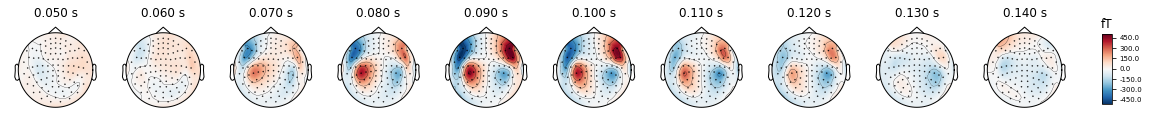

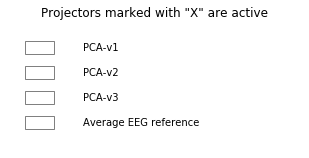

In [13]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
evoked = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                    proj='delayed', baseline=(None, 0),
                    reject=reject, verbose=False).average()

# set time instants in seconds (from 50 to 150ms in a step of 10ms)
times = np.arange(0.05, 0.15, 0.01)

fig = evoked.plot_topomap(times, proj='interactive', time_unit='s')

Now you should see checkboxes. Remove a few SSP and see how the auditory
pattern suddenly drops off



Exercises
---------

1) Can you compute your own proj using empty room data?

In [12]:
#compute own projector and add to data
erm_fname = data_path + 'sample/MEG/ernoise_raw.fif'
raw_erm = mne.io.read_raw_fif(erm_fname)
proj = mne.compute_proj_raw(raw_erm, start=0, stop=30)
raw.add_proj(projs, remove_existing=True)
raw.info['projs']

Opening raw data file /home/jovyan/mne_data/MNE-sample-datasample/MEG/ernoise_raw.fif...


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/mne_data/MNE-sample-datasample/MEG/ernoise_raw.fif'

2) How would you compute the SSP from the evoked baseline instead of empty room?

Adding projection: axial--0.200-0.000-PCA-01
Adding projection: axial--0.200-0.000-PCA-02


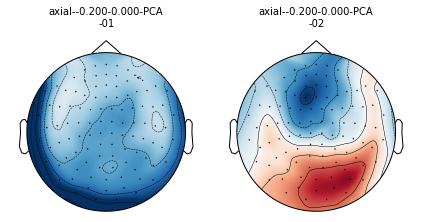

In [14]:
raw = mne.io.read_raw_fif(raw_fname, preload=True, verbose=False)
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
evoked = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                    proj='delayed', baseline=(None, 0),
                    reject=reject, verbose=False).average()

projs = mne.compute_proj_evoked(evoked.copy().crop(tmax=0), n_grad=0, n_mag=2, n_eeg=0)
mne.viz.plot_projs_topomap(projs, info=evoked.info);

Try making `reject=None`. What happens? Why?